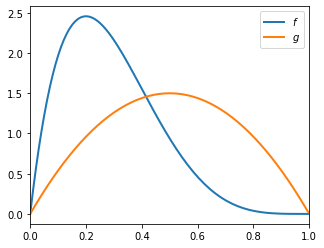

In [151]:
from scipy.stats import beta as β_distribution
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import LinearNDInterpolator
from scipy.integrate import fixed_quad
from scipy.stats import beta as β_distribution


x = np.linspace(0, 2, 200)
plt.figure(figsize=(5, 4))
plt.plot(x, β_distribution.pdf(x, 2,5, scale=1), label='$f$', lw=2)
plt.plot(x, β_distribution.pdf(x, 2, 2, scale=1), label='$g$', lw=2)
plt.xlim(0, 1)
plt.legend()
plt.show()

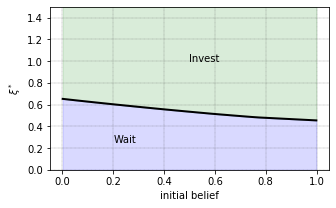

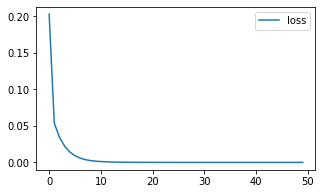

In [152]:
π_grid = np.linspace(0, 1, 41)
w_grid = np.linspace(0, 1, 41)

β=0.9
I=0.3
w_max=1
w_grid_size=41
π_grid_size=41
F = β_distribution(2, 5, scale=w_max)
G = β_distribution(2, 2, scale=w_max)
f, g = F.pdf, G.pdf    # Density functions
π_min, π_max = 1e-3, 1 - 1e-3  # Avoids instability
w_grid = np.linspace(0, w_max, w_grid_size)
π_grid = np.linspace(π_min, π_max, π_grid_size)


def q(w, π):
        new_π = 1.0 / (1 + ((1 - π) * g(w)) / (π * f(w)))

        # Return new_π when in [π_min, π_max] and else end points
        new_π = np.maximum(np.minimum(new_π, π_max), π_min)

        return new_π

def res_operator(ξ):
        
        # == Turn ξ into a function == #
        ξ_f = lambda p: np.interp(p, π_grid, ξ)

        new_ξ = np.empty(len(ξ))
        for i, π in enumerate(π_grid):
            def integrand(x):
                "Integral expression on right-hand side of operator"
                return np.maximum(x, ξ_f(q(x, π))) * (π * f(x) + (1 - π) * g(x))
            integral, error = fixed_quad(integrand, 0, w_max)
            new_ξ[i] = (1 - β) * I + β * integral

        return new_ξ
    
ξ = I*np.ones(len(π_grid))
ξ_old = ξ
loss_history = []
for i in range(50):
    ξ_new = res_operator(ξ_old)
    loss_history.append(np.abs(ξ_new-ξ_old).max())
    ξ_old = ξ_new
    if loss_history[-1]<=1e-10:
        break

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(π_grid, ξ_new, linewidth=2, color='black')
ax.set_ylim(0, 1.5)
ax.grid(axis='x', linewidth=0.25, linestyle='--', color='0.25')
ax.grid(axis='y', linewidth=0.25, linestyle='--', color='0.25')
ax.fill_between(π_grid, 0, ξ_new, color='blue', alpha=0.15)
ax.fill_between(π_grid, ξ_new, 1.5, color='green', alpha=0.15)
ax.text(0.2, 0.25, 'Wait')
ax.text(0.5, 1, 'Invest')
ax.set_xlabel("initial belief")
ax.set_ylabel("$ξ^*$")
plt.show()

fig, ax1 = plt.subplots(figsize=(5, 3))
ax1.plot(loss_history,label="loss")
ax1.legend()

plt.show()

In [153]:
index=np.where(π_grid==0.5)[0][0]
print(ξ_new[index],loss_history[-1])

0.5343021885055017 7.77190534151373e-11


In [158]:
T_max = 100 
ξ_star = lambda p: np.interp(p, π_grid, ξ_new)
def ForwardPass(π):
    steps = 0
    i = 0
    while i <= T_max:
        i = i+1
        w_sample = np.random.beta(2,2)
        π = q(w_sample,π)
        if w_sample >= ξ_star(π):
            steps = i
            break
    return steps

sample_size = 50
π_sizeNew = 31
π_gridNew = np.linspace(1e-3, 1 - 1e-3,π_sizeNew)
InvestTime = np.zeros((sample_size,len(π_gridNew)))

for ps,qs in enumerate(π_gridNew):
    for ss in range(sample_size):
        InvestTime[ss,ps] = ForwardPass(qs)

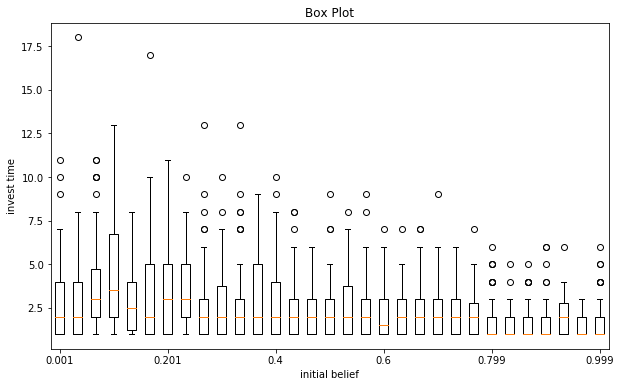

In [159]:
xlabel = np.linspace(1, π_sizeNew,int(π_sizeNew/5)).astype(int)
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(InvestTime)
ax.set_title("Box Plot")
#ax.set_ylim(0,8)
ax.set_xlabel("initial belief")
ax.set_ylabel("invest time")
plt.xticks(xlabel,π_gridNew.round(3)[xlabel-1])
plt.show()

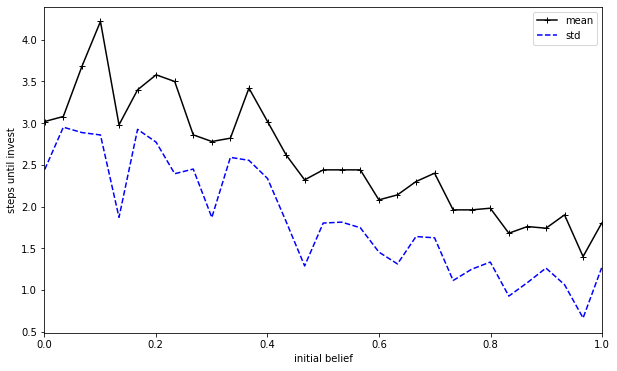

In [160]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(π_gridNew, InvestTime.mean(axis=0), '-+' ,color="black",label="mean")
ax.plot(π_gridNew, InvestTime.std(axis=0),'--', color="blue",label="std" )
ax.set_xlim(0,1)
ax.set_xlabel("initial belief")
ax.set_ylabel("steps until invest")
ax.legend()
plt.show()

In [161]:
index=np.where(π_grid==0.5)[0][0]
print(InvestTime.mean(axis=0)[index],InvestTime.std(axis=0)[index])

2.3 1.6401219466856725
